# Tutorial 4: Natural chromaticity.

# Objectives
#### - Quantify the natural **chromaticity of a FODO** 

<div>
<img src="../Figures/Tutorial4_chroma.jpg" width="500"/>
</div>

#### - First tracking of particles using the tracking MAD-X engine to study the beam dynamics of particles in the FODO for different initial conditions.

# Questions
#### 1. Using the lattice and the MAD-X input file from Tutorial 3 match the tunes of the FODO cell to 0.25, both horizontal and vertical.
#### 2. Using the chromaticities obtained from the TWISS, compute the tunes for $\Delta p / p = 10^{-3}$.
#### 3. Track a particle with initial coordinates x,y,px,py = (1,1,0,0) mm in 100 cells. Plot the x-px phase space.
#### 4. Track a particle with initial coordinates x,y,px,py=(100, 100, 0, 0) mm in 100 cells. Plot the x-px phase-space. Does something change with respect to the previous case? Why?
#### **BONUS**
#### 5. Repeat points 3 and 4 but adding DELTAP=1e-2 to the track command. How does the phase space look now? Is the tune still the same? It may help to look only at the first 4 turns to get a clearer picture.

# Python libraries 

In [2]:
#########################################
# Python libraries                      #
#########################################
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

#########################################
# Cpymad library                        #
#########################################
from cpymad.madx import Madx 

# Launching MAD-X

In [4]:
# madx = Madx(stdout=True)
madx = Madx()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.07.00  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2021.05.03               +
  + Execution date: 2022.12.30 13:12:36      +
  ++++++++++++++++++++++++++++++++++++++++++++


# Methods in the Madx class from cpymad library to be used:

#### To run the MAD-X lattice input file:

`madx.call('name_of_the_file.madx')`

#### To save the MAD-X output data from the TWISS and SUMM tables into a pandas dataframe: 

`madx.table.twiss.dframe()`

`madx.table.summ.dframe()`

#### To run a MAD-X command from the Jupyter-notebook: 

`madx.input("MAD-X command")`

# Python plot commands

#### You can copy/paste, uncomment and apply the example below for plotting:

In [3]:
###########################
#### Plot example code ####
###########################

#### To change the size of the plot window
# plt.rcParams['figure.dpi'] = 100

#### Plot command
# plt.plot(x,y,'ob',label='Example')

#### Adding labels
# plt.xlabel('s[m]')
# plt.ylabel('[m]')

#### Adding a legend
# plt.legend(loc='best')

# Solutions

#### 1. Using the lattice and the MAD-X input file from Tutorial 3 match the tunes of the FODO cell to 0.25, both horizontal and vertical. <a id="Q1"><a>

In [6]:
madx.call("Tutorial4_solution.madx")

! *********************************************************************

! Definition of parameters

! *********************************************************************



quadrupoleLength=5;

dipoleLength=15;

cellLength=100;

nBend=736;



myKF=0.0056;

myKD=-0.0056;



! *********************************************************************

! Definition of magnets

! ********************************************************************* 



QF: quadrupole, L=quadrupoleLength, K1:=myKF;

QD: quadrupole, L=quadrupoleLength, K1:=myKD;

BM: sbend, L=dipoleLength, angle=2*pi/nBend; 



! *********************************************************************

! Definition of sequence

! *********************************************************************



myCell:sequence, refer=CENTER, L=cellLength; ! already changed to centre

q1: QF, at=2.5;

B1: BM, at =17.5;

B2: BM, at =37.5;

q2: QD, at=52.5;

B3: BM, at =67.5;

B4: BM, at =87.5;

endsequence;







#### After loading the lattice, we can define the beam and activate the sequence.

In [7]:
myString='''
! *********************************************************************
! Definition of beam
! *********************************************************************

beam, particle=proton, energy=7000;

! *********************************************************************
! Use of the sequence
! *********************************************************************
use, sequence=myCell;

'''

madx.input(myString)

True

#### Then, we can perform the desired matching.

In [8]:
myString='''
! *********************************************************************
! TWISS BEFORE MATCHING
! *********************************************************************

twiss, table=beforematching, file="BeforeMatching.txt";

! *********************************************************************
! MATCHING
! *********************************************************************

MATCH, SEQUENCE=myCell;
GLOBAL, Q1=0.25;//H-tune
GLOBAL, Q2=0.25;//V-tune
VARY, NAME= myKF, STEP=0.00001;
VARY, NAME= myKD, STEP=0.00001;
LMDIF, CALLS=50, TOLERANCE=1e-6;//method adopted
ENDMATCH;

! *********************************************************************
! TWISS AFTER MATCHING
! *********************************************************************

twiss, file="AfterMatching.txt";


! *********************************************************************
! FINAL TUNE VALUES
! *********************************************************************

value, table(summ,Q1)*(nBend/4);
value, table(summ,Q2)*(nBend/4);

value, table(summ,dQ1);
value, table(summ,dQ2);
'''
madx.input(myString)

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               100                 -0    0.0006051853679        40.64955451 

                q1                dq1            betxmax              dxmax 
       0.236500685      -0.2917600666        160.5475138        2.444933737 

             dxrms             xcomax             xcorms                 q2 
       1.953527658                  0                  0       0.2363728498 

               dq2            betymax              dymax              dyrms 
     -0.2918567527        160.6036546                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

True

#### 2. Using the chromaticities obtained from the TWISS, compute the tunes for $\Delta p / p = 10^{-3}$. <a id="Q2"><a>

#### $\Delta Q = dq* \frac{\Delta p}{p}$


#### **REMEMBER** That the derivative functions in MAD-X are normalized by the relativistic factor beta.

#### We could assume ultra-relativistic beam.

#### Pythonic approach to get the relativistic beta factor for our beam

In [9]:
beta_rel=madx.sequence['mycell'].beam.beta
print (beta_rel)

0.9999999910167906


In [10]:
dq1_ref=madx.table['summ'].dq1[0]
print(dq1_ref)

-0.3177280082808754


In [11]:
# Variation on the tune
dq1_ref*beta_rel*1e-3

-0.0003177280054266581

#### This detuning is quite important, this is something that we will see more clear when tracking particles in the lattice.

In [12]:
#Tune of the machine
tune_onmomentum=madx.table['summ'].q1[0]
print(tune_onmomentum)
tune_offmomentum=madx.table['summ'].q1[0]-0.00031
print(tune_offmomentum)

0.25000012319209364
0.24969012319209363


#### 3. Track a particle with initial coordinates x,y,px,py = (1,1,0,0) mm in 100 cells. Plot the x-px phase space. 

#### **REMEMEBER** that in order to use the TRACK command you need to convert your lattice into a thin lattice. You will need the following commands:
    
        select, flag=MAKETHIN, SLICE=5;
        MAKETHIN, SEQUENCE=MY_SEQUENCE;
        use, sequence=MY_SEQUENCE;
        
#### **It is important when defining the SEQUENCE to refer to the the center, to make it compatible with the makethin command! So you may need to re-define the s location in your sequence accordingly.**

#### The track module to be use:
    
        track, dump;    
        start, x=1e-3, px=0, y=1e-3, py=0;    
        run, turns=100;   
        endtrack;  

#### Note that we need to rematch the lattice after the makethin to get again the target tune values.

In [13]:
myString='''

!*********************************************************************
! MAKETHIN
!*********************************************************************

select, flag=MAKETHIN, SLICE=1;
MAKETHIN, SEQUENCE=myCell;
use, sequence=myCell;

! *********************************************************************
! TWISS BEFORE MATCHING
! *********************************************************************

twiss, table=beforematching, file="BeforeMatching.txt";

! *********************************************************************
! MATCHING
! *********************************************************************

MATCH, SEQUENCE=myCell;
GLOBAL, Q1=0.25;//H-tune
GLOBAL, Q2=0.25;//V-tune
VARY, NAME= myKF, STEP=0.00001;
VARY, NAME= myKD, STEP=0.00001;
LMDIF, CALLS=50, TOLERANCE=1e-6;//method adopted
ENDMATCH;

! *********************************************************************
! TWISS AFTER MATCHING
! *********************************************************************

twiss, table=aftermatching, file="AfterMatching.txt";

! *********************************************************************
! FINAL TUNE VALUES
! *********************************************************************

value, table(summ,Q1)*(nBend/4);
value, table(summ,Q2)*(nBend/4);

value, table(summ,dQ1);
value, table(summ,dQ2);

!*********************************************************************
! TRACKING
!*********************************************************************

track,dump,file='linear_machine', DELTAP=0;
start, x= 1e-3, px=0, y= 1e-3, py=0;
run,turns=100;
endtrack;

value, table(SUMM, Q1);
value, table(SUMM, Q2);

'''
madx.input(myString);

makethin: slicing sequence : mycell
enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               100                 -0    0.0005003328404         44.7064819 

                q1                dq1            betxmax              dxmax 
      0.2614050987      -0.3418519641        173.5922928        2.176111981 

             dxrms             xcomax             xcorms                 q2 
       1.601895196                  0                  0       0.2614121955 

               dq2            betymax              dymax              dyrms 
     -0.3419299113        173.6224127                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                

#### When activating the option dump on the track module a new table is generated by MAD-X with the tracking results for each particle.

In [16]:
particle1=madx.table['track.obs0001.p0001'].dframe()

In [17]:
particle1.head()

,number,turn,x,px,y,py,t,pt,s,e
#e,1.0,0.0,0.001000,0.000000e+00,0.001000,0.000000e+00,0.000000e+00,0.0,0.0,7000.0
#e,1.0,1.0,-0.002313,-3.996889e-05,0.000514,-3.999234e-05,1.901141e-05,0.0,0.0,7000.0
#e,1.0,2.0,-0.001000,3.484334e-11,-0.001000,3.483156e-11,6.517432e-05,0.0,0.0,7000.0
#e,1.0,3.0,0.002313,3.996889e-05,-0.000514,3.999234e-05,4.593103e-05,0.0,0.0,7000.0
#e,1.0,4.0,0.001000,-6.968669e-11,0.001000,-6.966312e-11,-3.197748e-07,0.0,0.0,7000.0


(-5e-05, 5e-05)

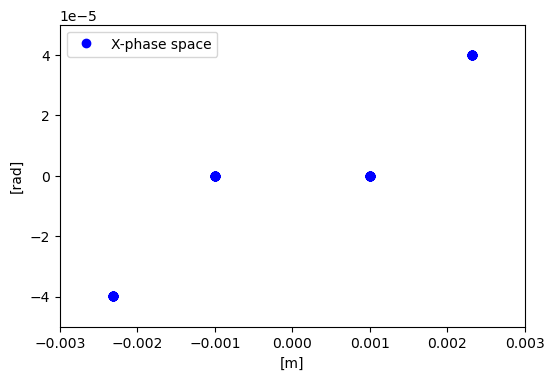

In [18]:
plt.rcParams['figure.dpi'] = 100
plt.plot(particle1['x'],particle1['px'],'ob',label='X-phase space')
#plt.plot(particle2['x'],particle2['px'],'or',label='X-phase space')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')
plt.xlim(-0.003,0.003)
plt.ylim(-5e-5, 5e-5)

#### In order to understand better the plot, it is useful to plot the different turns with dfferent markers and only up to the fifth turn.

(-5e-05, 5e-05)

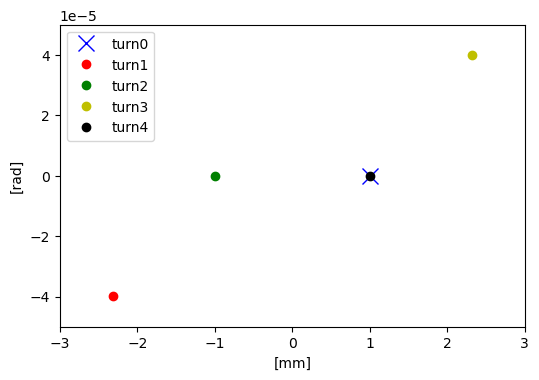

In [19]:
plt.rcParams['figure.dpi'] = 100
turn0=particle1[particle1["turn"]==0]
turn1=particle1[particle1["turn"]==1]
turn2=particle1[particle1["turn"]==2]
turn3=particle1[particle1["turn"]==3]
turn4=particle1[particle1["turn"]==4]
plt.plot(turn0['x']*1e3,turn0['px'],'xb',markersize=12,label='turn0')
plt.plot(turn1['x']*1e3,turn1['px'],'or',label='turn1')
plt.plot(turn2['x']*1e3,turn2['px'],'og',label='turn2')
plt.plot(turn3['x']*1e3,turn3['px'],'oy',label='turn3')
plt.plot(turn4['x']*1e3,turn4['px'],'ok',label='turn4')
plt.xlabel('[mm]')
plt.ylabel('[rad]')
plt.legend(loc='best')
plt.xlim(-3,3)
plt.ylim(-5e-5, 5e-5)

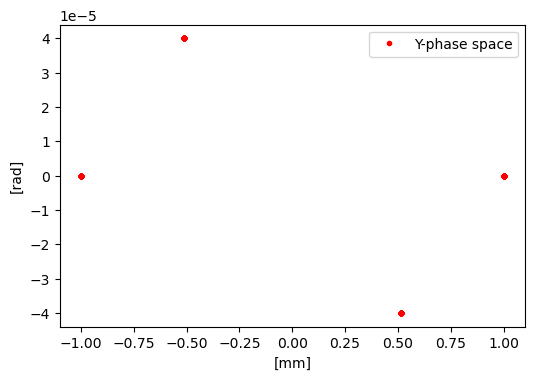

In [20]:
# Plot visualization options
plt.rcParams['figure.dpi'] = 100
plt.plot(particle1['y']*1e3,particle1['py'],'.r',label='Y-phase space')
plt.xlabel('[mm]')
plt.ylabel('[rad]')
plt.legend(loc='best')

(-5e-05, 5e-05)

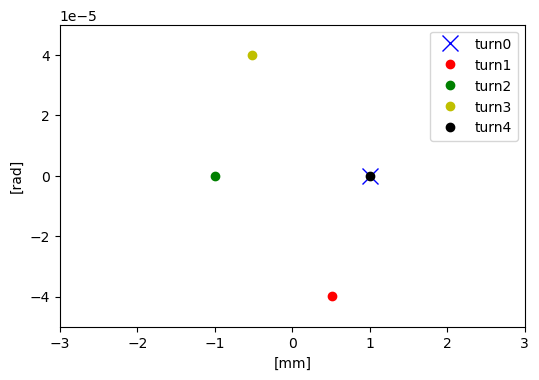

In [21]:
plt.rcParams['figure.dpi'] = 100
turn0=particle1[particle1["turn"]==0]
turn1=particle1[particle1["turn"]==1]
turn2=particle1[particle1["turn"]==2]
turn3=particle1[particle1["turn"]==3]
turn4=particle1[particle1["turn"]==4]
plt.plot(turn0['y']*1e3,turn0['py'],'xb',markersize=12,label='turn0')
plt.plot(turn1['y']*1e3,turn1['py'],'or',label='turn1')
plt.plot(turn2['y']*1e3,turn2['py'],'og',label='turn2')
plt.plot(turn3['y']*1e3,turn3['py'],'oy',label='turn3')
plt.plot(turn4['y']*1e3,turn4['py'],'ok',label='turn4')
plt.xlabel('[mm]')
plt.ylabel('[rad]')
plt.legend(loc='best')
plt.xlim(-3,3)
plt.ylim(-5e-5, 5e-5)

#### 4. Track a particle with initial coordinates x,y,px,py=(100, 100, 0, 0) mm in 100 cells. Plot the x-px phase-space. Does something change with respect to the previous case? Why?

In [23]:
myString='''
//*************************************************//
!   TRACKING
//*************************************************//

track,dump,file='linear_machine', DELTAP=0.00;
start, x= 1e-1, px=0, y= 1e-1, py=0;
run,turns=100;
endtrack;

'''
madx.input(myString);

enter TRACK module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

Full 6D closed orbit search.
Initial value of 6-D closed orbit from Twiss: 
orbit0   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  Singular matrix occurred during closed orbit search.

6D closed orbit found by subroutine trclor 
iteration:   2 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: tracksumm

                 x                 px 
         1          0                0.1                  0 
         1        100      0.09943523048   -9.755103557e-06 

                 y                 py                  t                 pt 
               0.1                  0                  0                  0 
      0.1001252194    -9.76262834e-06     -0.07994507736       

In [24]:
particle2=madx.table['track.obs0001.p0001'].dframe()

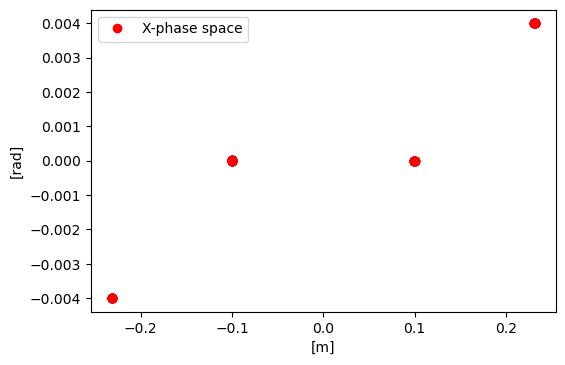

In [25]:
plt.rcParams['figure.dpi'] = 100
#plt.plot(particle1['x'],particle1['px'],'ob',label='X-phase space')
plt.plot(particle2['x'],particle2['px'],'or',label='X-phase space')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')
#plt.xlim(-0.003,0.003)
#plt.ylim(-5e-5, 5e-5)

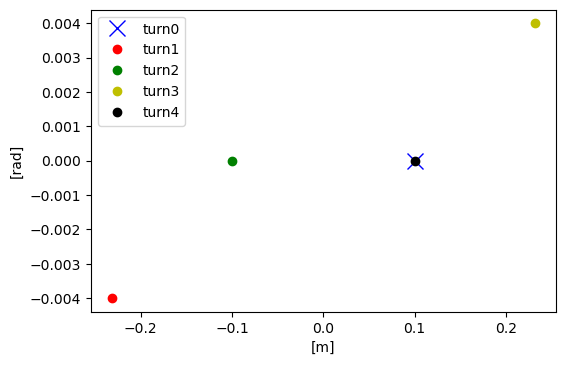

In [26]:
# Plot visualization options
plt.rcParams['figure.dpi'] = 100

turn0=particle2[particle2["turn"]==0]
turn1=particle2[particle2["turn"]==1]
turn2=particle2[particle2["turn"]==2]
turn3=particle2[particle2["turn"]==3]
turn4=particle2[particle2["turn"]==4]
plt.plot(turn0['x'],turn0['px'],'xb',markersize=12,label='turn0')
plt.plot(turn1['x'],turn1['px'],'or',label='turn1')
plt.plot(turn2['x'],turn2['px'],'og',label='turn2')
plt.plot(turn3['x'],turn3['px'],'oy',label='turn3')
plt.plot(turn4['x'],turn4['px'],'ok',label='turn4')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')

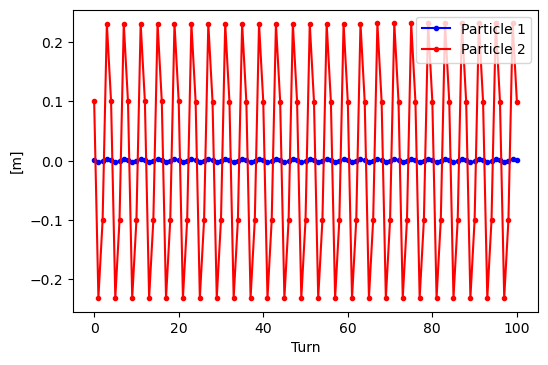

In [27]:
# We can also plot the amplitude of the particle vs the turn number
# Plot visualization options
plt.rcParams['figure.dpi'] = 100
plt.plot(particle1['turn'],particle1['x'],'.-b', label='Particle 1')
plt.plot(particle2['turn'],particle2['x'],'.-r', label='Particle 2')
plt.xlabel('Turn')
plt.ylabel('[m]');
plt.legend(loc='best');

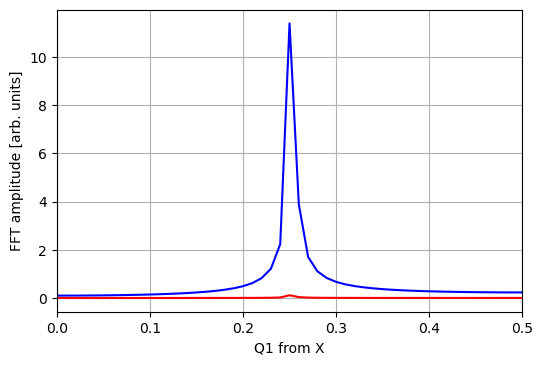

In [28]:
plt.rcParams['figure.dpi'] = 100

# The amplitude of the FFT of the particle amplitude oscilations gives as a mesure of the tune
# Just play with an FFT on 
plt.figure()
plt.plot(np.linspace(0,1,len(particle1['x'])), np.abs(np.fft.fft(particle1['x'])), 'r')
plt.plot(np.linspace(0,1,len(particle2['x'])), np.abs(np.fft.fft(particle2['x'])), 'b')
plt.xlabel('Q1 from X')
plt.ylabel('FFT amplitude [arb. units]');
plt.xlim(0,0.5)# The max. possible frequency for a given sampling rate that can be reconstruct is given by the Nyquist limit= sampling frecuency/2. In our case the sampling rate is 1, so the limit is 0.5.
plt.grid()

Answer: We obtain a similar plot as before but with larger amplitues.

#### **BONUS**

#### 5. Repeat points 3 and 4 but adding DELTAP=1e-2 to the track command. How does the phase space look now? Is the tune still same? It may help to look only at the first 4 turns to get a clearer picture.

In [29]:
myString='''
//*************************************************//
!   TRACKING
//*************************************************//

track,dump,file='linear_machine_off_energy', DELTAP=0.01;
start, x= 1e-3, px=0, y= 1e-3, py=0;
start, x= 1e-1, px=0, y= 1e-1, py=0;
run,turns=100;
endtrack;

'''
madx.input(myString);

enter TRACK module
track_deltap:               0.01
  
iteration:   1 error:   2.167801E-02 deltap:   1.000000E-02
orbit:   2.246269E-02  3.258240E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   3.469447E-18 deltap:   1.000000E-02
orbit:   2.246269E-02  3.258240E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: tracksumm

      turn                  x                 px 
         1          0              0.001                  0 
         2          0                0.1                  0 
         1        100     0.002184671656    4.784742909e-05 
         2        100       0.1722802632     0.003662241955 

                 y                 py                  t                 pt 
             0.001                  0                  0     0.009999999911 
               0.1                  0                  0     0.009999999911 
  -0.0008659736043    3.648859851e-05     -0.05480574959     0.009999999911 
    -0.08

In [30]:
off_momentum_particle1=madx.table['track.obs0001.p0001'].dframe()
off_momentum_particle2=madx.table['track.obs0001.p0002'].dframe()

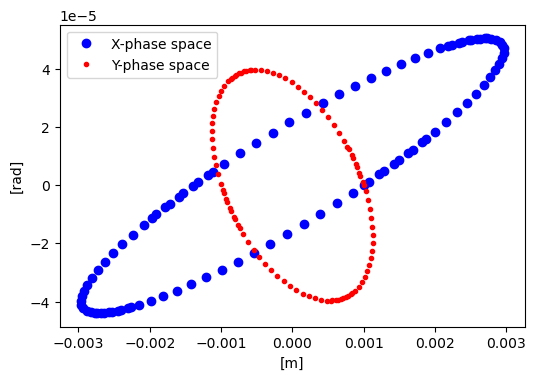

In [31]:
plt.rcParams['figure.dpi'] = 100

plt.plot(off_momentum_particle1['x'],off_momentum_particle1['px'],'ob',label='X-phase space')
plt.plot(off_momentum_particle1['y'],off_momentum_particle1['py'],'.r',label='Y-phase space')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')

#### The same plot for larger amplitudes

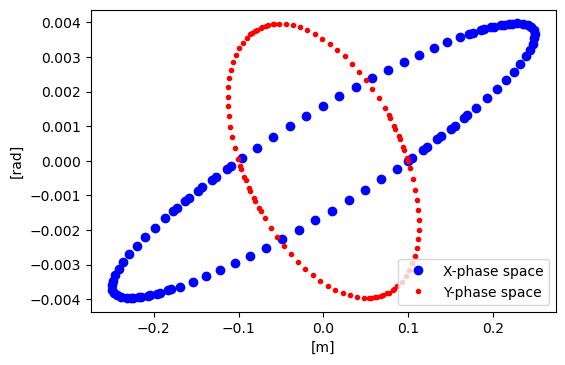

In [32]:
plt.rcParams['figure.dpi'] = 100

plt.plot(off_momentum_particle2['x'],off_momentum_particle2['px'],'ob',label='X-phase space')
plt.plot(off_momentum_particle2['y'],off_momentum_particle2['py'],'.r',label='Y-phase space')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')

#### As we track off-momentum particles the tune is afected by the natural chromaticity of the FODO and it is not 0.25 anymore.

#### The observed effect is small, however in machines with stronger quadrupoles the impact could be higher and correction schemes are needed such as the one we will design in the next tutorial.